In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
from pylab import rcParams
from scipy.stats import pearsonr
plt.style.use('seaborn')
%matplotlib inline

# Analysis of Cycling Data

This data is about a log of cycling from a man, and time starting from 2018. 
He use the app called [Strava](https://strava.com/). The data contain like the distance, heart rate, temperature. Today, I will introduce my analysis about this data.	

## Loading Data

The script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

First, I read the first data in here.

In [2]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava['elevation_gain']= strava.elevation_gain.str.replace('m', '').astype(float)
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.0,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.0,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.0,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.0,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.0,12,144,Ride


The second data was collected by an app called GoldenCheetah, and it can do some simple analysis for the ride data. So, we can observe two dataframe and see that whether there is someting interesting in here.

In [3]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


## Combine two data

In [4]:
df= strava.join(cheetah,how='inner')
compression_opts = dict(method='zip',archive_name='qwert.csv')  
df.to_csv('qwert.zip', index=False,compression=compression_opts)
df.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.0,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.0,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-01-31 21:13:34+00:00,109.8,19.0,143.0,False,26.3,649,612.0,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.0,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.0,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


## Remove the column" device_watts" is 'False'.

In [5]:
df['device_watts']= df.device_watts.astype(str).replace('True', '1')
df['device_watts']= df.device_watts.astype(str).replace('False', '2')
indexNames = df[ (df['device_watts'] == '2')].index
df.drop(indexNames , inplace=True)
df['device_watts']= df.device_watts.astype(str).replace('1', 'True')

# Data Exploring

Look the distribution in each variables.

Text(0, 0.5, 'Frequency')

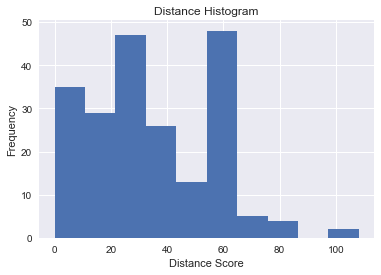

In [6]:
hist_distance = df['distance'].hist()
hist_distance.set_title('Distance Histogram')
hist_distance.set_xlabel('Distance Score')
hist_distance.set_ylabel('Frequency')

It is a right-skewed distribution.

Text(0, 0.5, 'Frequency')

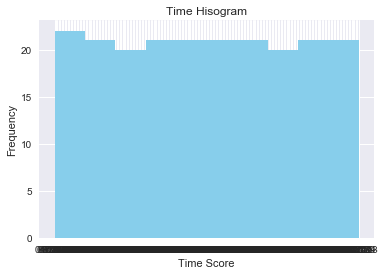

In [7]:
hist_time = df['time'].hist(color='skyblue')
hist_time.set_title('Time Hisogram')
hist_time.set_xlabel('Time Score')
hist_time.set_ylabel('Frequency')

It is a uni distribution.

Text(0, 0.5, 'Frequency')

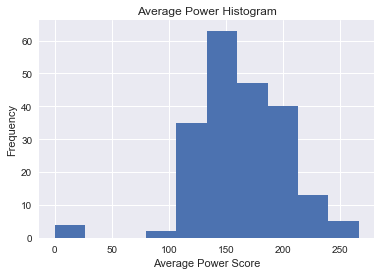

In [8]:
hist_AveragePower = df['Average Power'].hist()
hist_AveragePower.set_title('Average Power Histogram')
hist_AveragePower.set_xlabel('Average Power Score')
hist_AveragePower.set_ylabel('Frequency')

It is a left-skewed distribution.

Text(0, 0.5, 'Frequency')

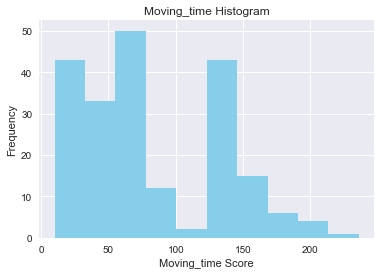

In [9]:
hist_time = df['moving_time'].hist(color='skyblue')
hist_time.set_title('Moving_time Histogram')
hist_time.set_xlabel('Moving_time Score')
hist_time.set_ylabel('Frequency')

It is a right-skewed distribution.

Text(0, 0.5, 'Frequency')

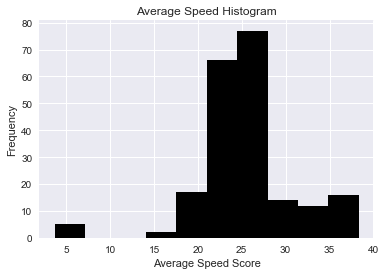

In [10]:
hist_Average_Speed = df['Average Speed'].hist(color='black')
hist_Average_Speed.set_title('Average Speed Histogram')
hist_Average_Speed.set_xlabel('Average Speed Score')
hist_Average_Speed.set_ylabel('Frequency')

It is a left-skewed distribution.

Text(0, 0.5, 'Frequency')

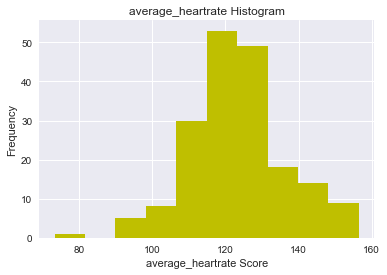

In [11]:
hist= df['average_heartrate'].hist(color='y')
hist.set_title('average_heartrate Histogram')
hist.set_xlabel('average_heartrate Score')
hist.set_ylabel('Frequency')

It close to normal distribution.

Text(0, 0.5, 'Frequency')

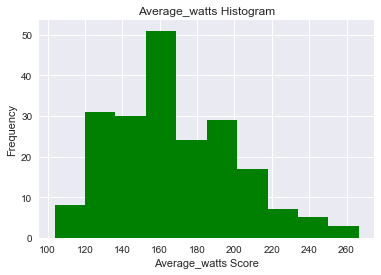

In [12]:
hist= df['average_watts'].hist(color='g')
hist.set_title('Average_watts Histogram')
hist.set_xlabel('Average_watts Score')
hist.set_ylabel('Frequency')

It is a right-skewed distribution.

Text(0, 0.5, 'Frequency')

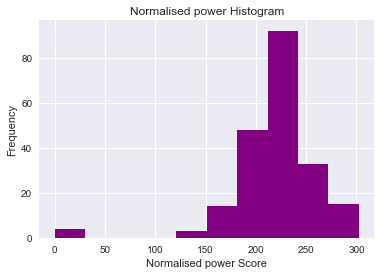

In [13]:
hist= df['NP'].hist(color='purple')
hist.set_title('Normalised power Histogram')
hist.set_xlabel('Normalised power Score')
hist.set_ylabel('Frequency')

It is a left-skewed distribution.

Text(0, 0.5, 'Frequency')

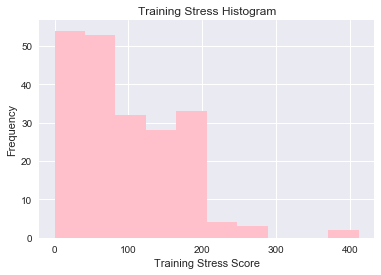

In [14]:
hist= df['TSS'].hist(color='pink')
hist.set_title('Training Stress Histogram')
hist.set_xlabel('Training Stress Score')
hist.set_ylabel('Frequency')

It is a right-skewed distribution.

Text(0, 0.5, 'Frequency')

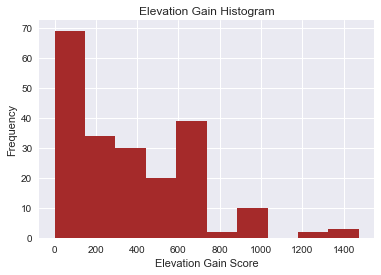

In [15]:
hist= df['elevation_gain'].hist(color='brown')
hist.set_title('Elevation Gain Histogram')
hist.set_xlabel('Elevation Gain Score')
hist.set_ylabel('Frequency')

It is a right-skewed distribution.

# Data cleaning

In [16]:
df.dropna(inplace=True)

Make sure all data without N/A

In [17]:
df.isnull().values.any()

False

We can make sure that there is no null value in this dataframe.

# Correaltion matrix (Heat-map)

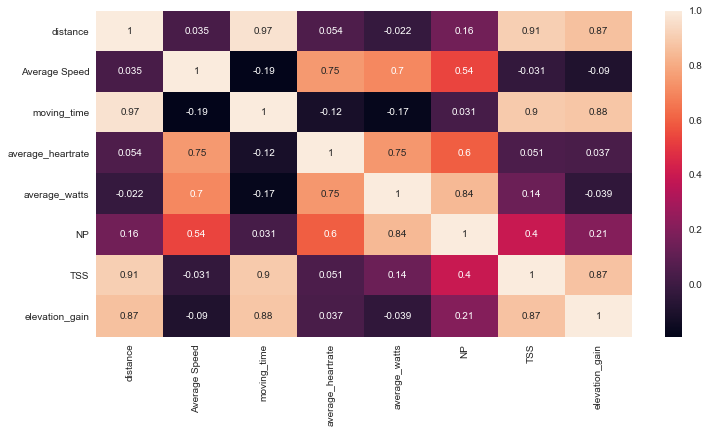

In [18]:
plt.figure(figsize=(12,6))
df_heatmap=df[['distance','Average Speed','moving_time','average_heartrate','average_watts','NP','TSS','elevation_gain']]
sns.heatmap(df_heatmap.corr(),annot=True)

In this graph, there are several points in here:

1. The more distances, and it need more moving_time to arrive the destination.
2. The more distances, it will accumulate more training stress in body.
3. The more distances, and it need more elevation_gain to arrive the destination.
4. When the rider has more average speed, the average heart rate will increase.
5. The more average speed the rider needs, the more power(average_watts)
6. The more moving_time, it will accumulate more training stress in body.
7. The more moving_time, and it need more elevation_gain to arrive the destination.

# Measuring the most challenging rides in dataframe.

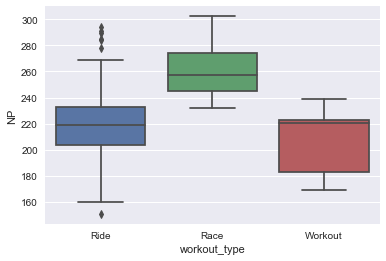

In [19]:
sns.boxplot(x='workout_type', y='NP', data=df)

We can know that races are more challenging than rides in general from Normalised power (NP), because the man needs to spend much more power in race.

# Convert time zone from UTC to Australia/Sydney

In [20]:
df.index
df_strava=strava.tz_convert('Australia/Sydney')

Merge a new datafrmae between df_strava and cheetah in same time zone(Australia/Sydney)

In [21]:
df_strava.index
df2= df_strava.join(cheetah,how='inner')
df2.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,120.6,21.0,153.4,True,7.6,17,95.0,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,146.9,22.0,187.7,True,38.6,67,449.0,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,109.8,19.0,143.0,False,26.3,649,612.0,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,119.3,19.0,165.9,True,24.3,69,439.0,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,124.8,20.0,151.0,True,47.1,144,890.0,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


Changing the date into a new form from 2018-01-28 06:39:49+11:00 to 2018-1, it helps us to reconginze when the month is.

In [22]:
df2['date'] = pd.to_datetime(df2['date']).dt.to_period('M')

Using groupby to let me know the distance in each month.
Also, I create a new dataframe for explaining these data.

In [23]:
x_distance_in_moonth=df2.groupby('date')['distance'].sum()
x_distance_in_moonth = pd.DataFrame(data=x_distance_in_moonth)

Build a new colmun to calulate the number of TSS and Average Speed.
Using groupby to let me know the sum of TSS and Average Speed in each month.

In [24]:
df2['TSSplusAverage']=df2['TSS']+df2['Average Speed']
sum_of_TTSplusAverageSpeed=df2.groupby('date')['TSSplusAverage'].sum()

Put the data (TSS and Average Speed) into the new dataframe

In [25]:
x_distance_in_moonth['sum_of_TSS&AverageSpeed']=sum_of_TTSplusAverageSpeed
x_distance_in_moonth.head()

,distance,sum_of_TSS&AverageSpeed
date,,
2018-01,46.2,175.2658
2018-02,476.8,1439.3704
2018-03,508.0,1707.9289
2018-04,450.2,1600.2282
2018-05,339.5,934.9800


Show the bar plot for these data

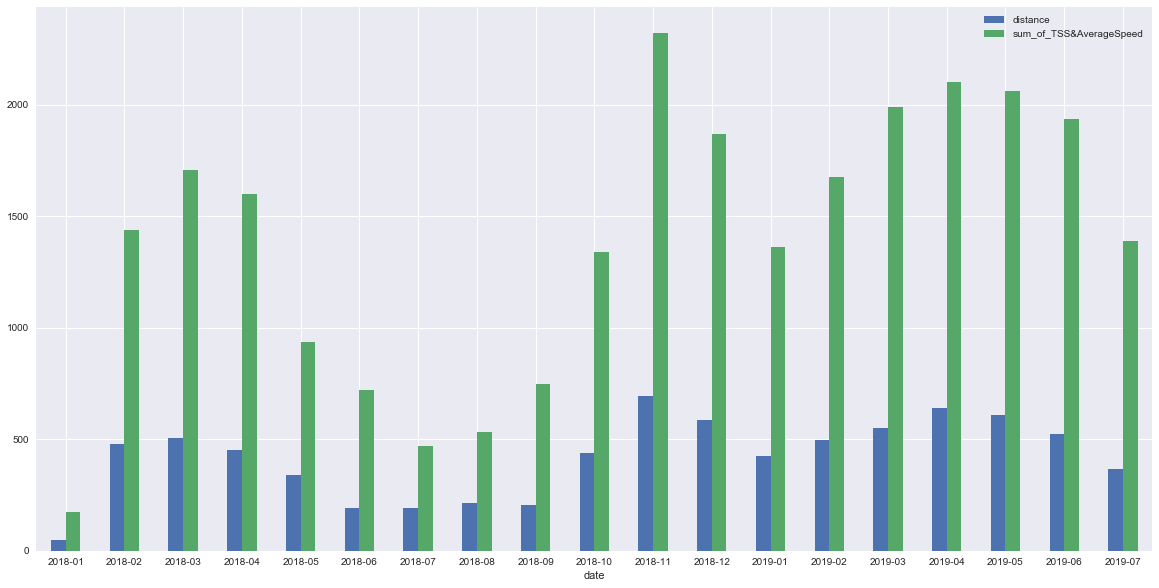

In [26]:
rcParams['figure.figsize'] =(20,10)
ax = x_distance_in_moonth.plot.bar(rot=0)

# Show the high correlation with kudos

In [27]:
for i in range(0,len(df.columns)):
    for j in range(i+1,len(df.columns)):
        col_i_name=df.columns[i]
        col_j_name=df.columns[j]
        
        if df[col_i_name].dtype !='int64':
            continue
            
        if df[col_j_name].dtype !='int64':
            continue
        
        r,p=pearsonr(df[col_i_name],df[col_j_name])
        
        if r >0.5:
            print(col_i_name,col_j_name,r,p)
        

elapsed_time kudos 0.6171707608423216 1.7574493472771415e-16
elapsed_time moving_time 0.9716846413551611 7.31734853222092e-91
elapsed_time Duration 0.9999917325233524 0.0
elapsed_time Time Moving 0.9723058534645508 1.5480109295793717e-91
elapsed_time Time Carrying (Est) 0.7295833399098762 3.3695011598102776e-25
elapsed_time H1 Time in Zone 0.7361136802103943 7.69519857560537e-26
elapsed_time H2 Time in Zone 0.797434976667095 5.86244364308773e-33
elapsed_time H3 Time in Zone 0.7711682300298262 1.2244910309528046e-29
elapsed_time P1 Time in Pace Zone 0.6905004913812839 1.0199090399240617e-21
elapsed_time P2 Time in Pace Zone 0.7615105569520559 1.582559273041851e-28
elapsed_time P3 Time in Pace Zone 0.6950183482330318 4.312018883862767e-22
elapsed_time P4 Time in Pace Zone 0.6790426594957774 8.449270864379895e-21
elapsed_time P5 Time in Pace Zone 0.8100910498194351 9.736148476221617e-35
elapsed_time P6 Time in Pace Zone 0.9479542474729765 1.8678907489818324e-72
elapsed_time L7 Sustained T

/Users/garyhsu/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 H1 Time in Zone 0.7143080466880092 9.064935934664492e-24
Time Moving H2 Time in Zone 0.8063965330081976 3.32228579662446e-34
Time Moving H3 Time in Zone 0.8191448108720802 4.278381417309583e-36
Time Moving P1 Time in Pace Zone 0.7118129502212411 1.520760607946746e-23
Time Moving P2 Time in Pace Zone 0.7993533473221014 3.210252369978711e-33
Time Moving P3 Time in Pace Zone 0.7457438487129454 8.034478788446312e-27
Time Moving P4 Time in Pace Zone 0.7407453752908421 2.628456857134396e-26
Time Moving P5 Time in Pace Zone 0.8494801448696043 2.913453964366355e-41
Time Moving P6 Time in Pace Zone 0.965576298636961 6.232992614669779e-85
Time Moving L7 Sustained Time 0.5053507869802107 1.0481722603604264e-10
Time Moving L1 Time in Zone 0.9601730023466002 1.6141235858125145e-80
Time Moving L2 Time in Zone 0.8977968384371389 1.9898848398209687e-52
Time Moving L3 Time in Zone 0.8700739180888364 1.8152046164747007e-45
Time Moving L4 Time in Zone 0.8736295067771243 2.8850977630353846e-46
Time Movin

1 sec Peak Power L7 Sustained Time 0.5201183443018375 2.3711612987364883e-11
1 sec Peak Power L7 Time in Zone 0.636960686150174 9.333228623702301e-18
1 sec Peak Power W'bal Matches 0.6779493622857581 1.028657135870926e-20
1 sec Peak Power W2 Above CP W'bal Moderate Fatigue 0.558994116609111 3.3016422543837916e-13
1 sec Peak Power W2 W'bal Moderate Fatigue 0.5990113326005027 2.1787170504131018e-15
L4 Sustained Time L6 Sustained Time 0.5528063038615998 6.766638308516743e-13
L4 Sustained Time W3 Above CP W'bal Heavy Fatigue 0.574732631961246 4.969818706074999e-14
L4 Sustained Time W4 Above CP W'bal Severe Fatigue 0.6110492716838896 4.1809351188238163e-16
L4 Sustained Time W3 W'bal Heavy Fatigue 0.5516722340657014 7.705421677184789e-13
L4 Sustained Time W4 W'bal Severe Fatigue 0.6477970879521882 1.7060013144038977e-18
L5 Sustained Time L6 Sustained Time 0.6934711622821174 5.800889522368726e-22
L5 Sustained Time L4 Time in Zone 0.5164828554744267 3.4415099000992485e-11
L5 Sustained Time L5 

In this list, I pick up several combinations that the high correaltion columns with kudos.

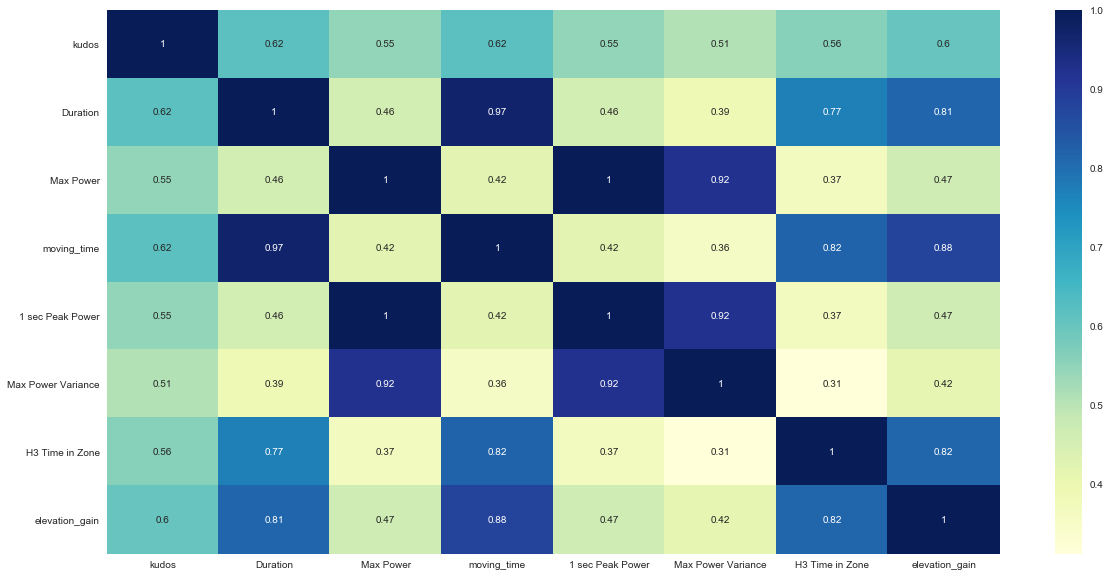

In [28]:
df_new_heatmap=df[['kudos','Duration','Max Power','moving_time','1 sec Peak Power','Max Power Variance','H3 Time in Zone','elevation_gain']]
sns.heatmap(df_new_heatmap.corr(),annot=True,cmap="YlGnBu")

In this graph, there are several points in here:
    
1.The more duration, and the rider have the high opportunity to get more kudos.

2.The more moving_time, and the rider have the high opportunity to get more kudos.

3.The more moving_time, and it needs more duration in this ride.

4.The more duration, and the higher H3 Time in Zone the rider has.

5.The more duration, and it needs more elevation_gain in this ride.

6.The more moving_time, and the higher H3 Time in Zone the rider has.

7.The more moving_time, and it needs more elevation_gain in this ride.

8.The more max power variance, and it can creat the max speed in 1 second.

9.The more H3 time in zone, and it needs more elevation_gain in this ride.

In this heatmap, we can know that the more distance kudos,Duration,Max Power,moving_time,1 sec Peak Power,Max Power Variance,H3 Time in Zone, and elevation_gain, the more kudos we can get.

# Generate the number of activities in each month.

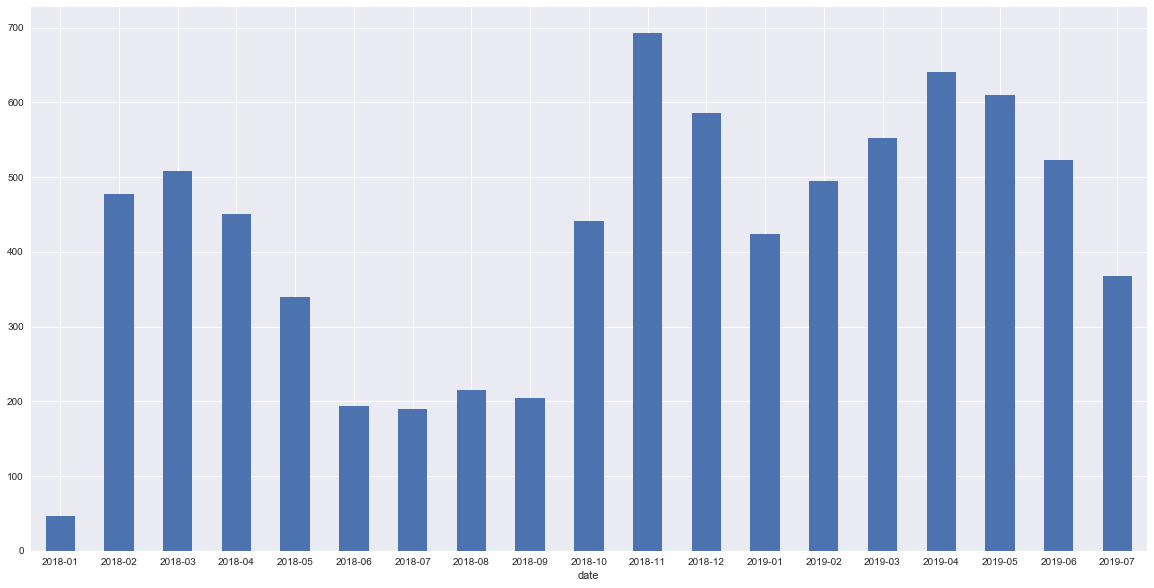

In [29]:
ax = x_distance_in_moonth.distance.plot.bar(rot=0)

The man attent more and more activities from Feb to May, and he decreased the number of activities in the second haif of year.